# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



In [1]:
import os
import sys
import random
import warnings
from random import randint, randrange

import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from skimage.color import rgb2gray
from skimage import exposure

import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

---
## Step 0: Load The Data

There are tables which contain 'classid' and 'SignName' for traffic sign data in 'signnames.csv' file

In [2]:
sign_names = pd.read_csv('signnames.csv')

In [3]:
sign_names

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


I'm going to make look up table for traffic sign

In [4]:
sign_table = {}

for cid, sname in zip(sign_names['ClassId'], sign_names['SignName']):
    sign_table[cid] = sname

In [5]:
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Make validation data from 'train', about 20%
x_train, x_valid, y_train, y_valid = train_test_split(train['features'], train['labels'], test_size=0.2)
x_test, y_test = test['features'], test['labels']


The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

---

## Step 1: Check Data

In [6]:
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
n_classes = class_counts.shape[0]

sign = sign_names.values[:, 1]
col_width = max(len(name) for name in sign)
CLASS_NUM = len(sign_table)
print("We should classify images to {0} classes".format(CLASS_NUM))

We should classify images to 43 classes


In [7]:
print("train data: {0} samples".format(len(x_train)))
print("valid data: {0} samples".format(len(x_valid)))
print("test data: {0} samples".format(len(x_test)))
print("Image data shape ={}\n\n".format(x_train.shape[1:]))

TOTAL_SIZE = len(x_train) + len(x_valid) + len(x_test)

print("train data: {} %%".format(len(x_train)/TOTAL_SIZE))
print("valid data: {} %%".format(len(x_valid)/TOTAL_SIZE))
print("test data: {} %%".format(len(x_test)/TOTAL_SIZE))

train data: 31367 samples
valid data: 7842 samples
test data: 12630 samples
Image data shape =(32, 32, 3)


train data: 0.6050849746329984 %%
valid data: 0.1512760662821428 %%
test data: 0.24363895908485889 %%


In [8]:
print("Task of this project is classify {0} traffic sign images to {1} classes".format(TOTAL_SIZE, CLASS_NUM))

Task of this project is classify 51839 traffic sign images to 43 classes


### Visualize Data


 Text is not enough, Let's look real image not a number. Le't plot 4 traffic sign samples from train data

In [9]:
def plot_images(images, labels):
    fig, axes = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=1, wspace=0.5)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i])
        
        # Class name
        sign_name = sign_table[labels[i]]
        
        ax.set_xlabel(sign_name)
    
    plt.show()

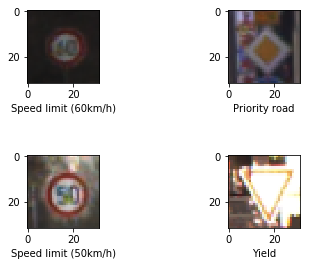

In [10]:
plot_images(x_train[:4], y_train[:4])

### Let's check how signs look like each class


Class 0: Speed limit (20km/h)                                167 samples


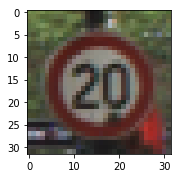

Class 1: Speed limit (30km/h)                                1734 samples


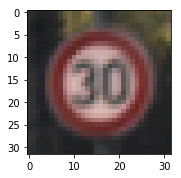

Class 2: Speed limit (50km/h)                                1832 samples


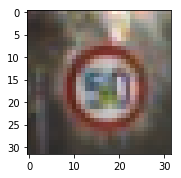

Class 3: Speed limit (60km/h)                                1126 samples


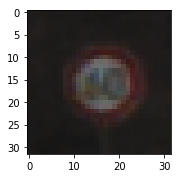

Class 4: Speed limit (70km/h)                                1565 samples


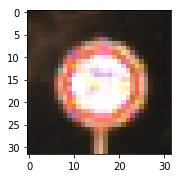

Class 5: Speed limit (80km/h)                                1491 samples


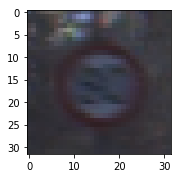

Class 6: End of speed limit (80km/h)                         349 samples


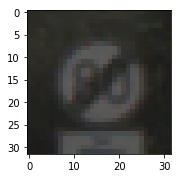

Class 7: Speed limit (100km/h)                               1147 samples


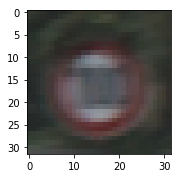

Class 8: Speed limit (120km/h)                               1114 samples


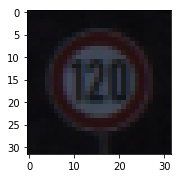

Class 9: No passing                                          1190 samples


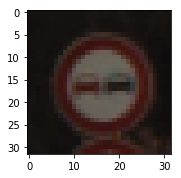

Class 10: No passing for vehicles over 3.5 metric tons        1627 samples


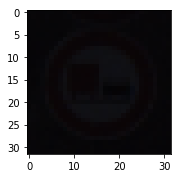

Class 11: Right-of-way at the next intersection               1041 samples


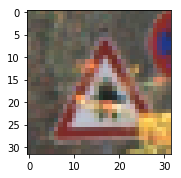

Class 12: Priority road                                       1662 samples


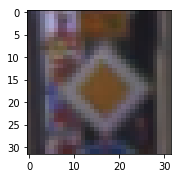

Class 13: Yield                                               1702 samples


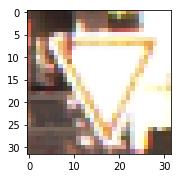

Class 14: Stop                                                637 samples


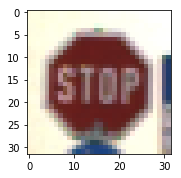

Class 15: No vehicles                                         488 samples


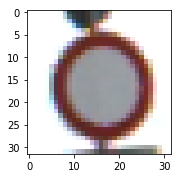

Class 16: Vehicles over 3.5 metric tons prohibited            340 samples


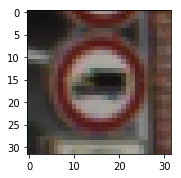

Class 17: No entry                                            882 samples


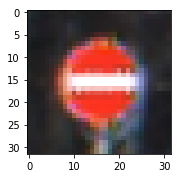

Class 18: General caution                                     969 samples


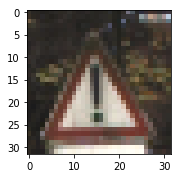

Class 19: Dangerous curve to the left                         169 samples


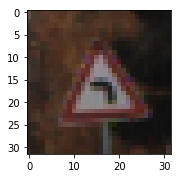

Class 20: Dangerous curve to the right                        289 samples


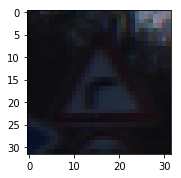

Class 21: Double curve                                        266 samples


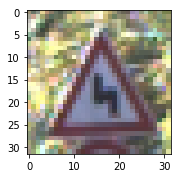

Class 22: Bumpy road                                          315 samples


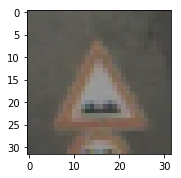

Class 23: Slippery road                                       408 samples


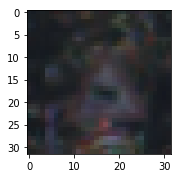

Class 24: Road narrows on the right                           223 samples


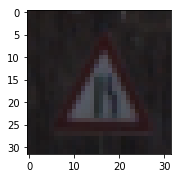

Class 25: Road work                                           1204 samples


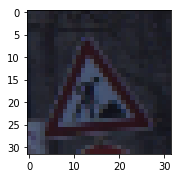

Class 26: Traffic signals                                     489 samples


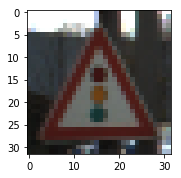

Class 27: Pedestrians                                         200 samples


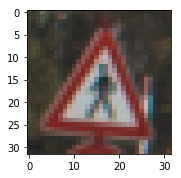

Class 28: Children crossing                                   443 samples


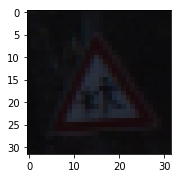

Class 29: Bicycles crossing                                   210 samples


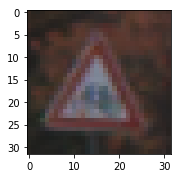

Class 30: Beware of ice/snow                                  355 samples


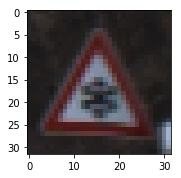

Class 31: Wild animals crossing                               635 samples


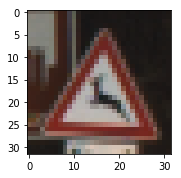

Class 32: End of all speed and passing limits                 181 samples


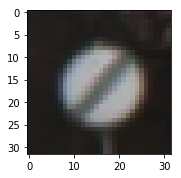

Class 33: Turn right ahead                                    539 samples


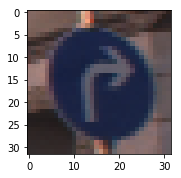

Class 34: Turn left ahead                                     344 samples


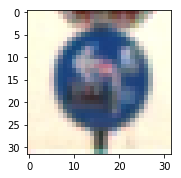

Class 35: Ahead only                                          977 samples


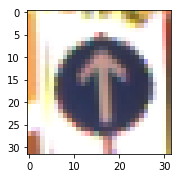

Class 36: Go straight or right                                313 samples


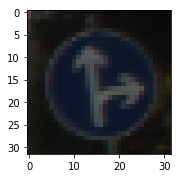

Class 37: Go straight or left                                 176 samples


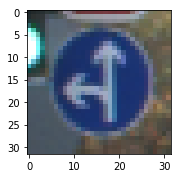

Class 38: Keep right                                          1659 samples


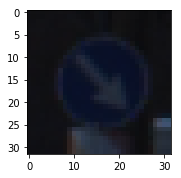

Class 39: Keep left                                           255 samples


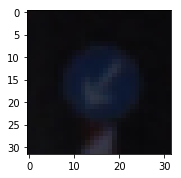

Class 40: Roundabout mandatory                                277 samples


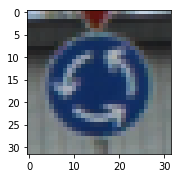

Class 41: End of no passing                                   179 samples


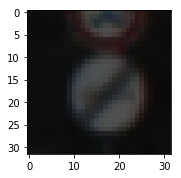

Class 42: End of no passing by vehicles over 3.5 metric tons  198 samples


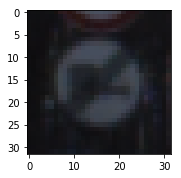

In [11]:
for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("Class %i: %-*s  %s samples" % (c, col_width, sign[c], str(c_count)))
    fig = plt.figure(figsize = (2, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    
    axis = fig.add_subplot(1, 1, 1)
    axis.imshow(x_train[c_index])
        
    plt.show()



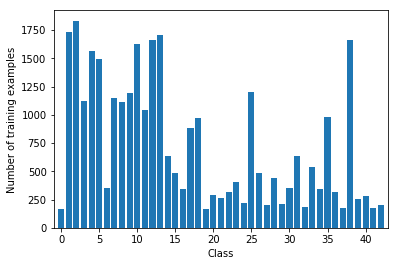

In [12]:
plt.bar(np.arange(43), class_counts, align='center')
plt.xlabel('Class')
plt.ylabel('Number of training examples')
plt.xlim([-1, 43])
plt.show()

---

## Design and Test a Model Architecture

### Pre-process the Data Set

3-channels color is not neccesary to get high accuracy as [paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) address. So, I preprocess images with grayscale and normalization through tensorflow method. To get more clear gray-scale images, I also apply 'Histogram equalization' technique. Histogram equalization is a technique for adjusting images intensities to enhance contrast.

In [13]:
def preprocess_image(images):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        # gray scale
        gray_scaled = rgb2gray(images)
        # normalize
        normalized = (gray_scaled/255).astype(np.float32)
        sample_size = len(gray_scaled)

        # Histogram equalization
        for i in range(sample_size):
            #sys.stdout.write('\r'+str(i*100/sample_size))
            #sys.stdout.flush()
            normalized[i] = exposure.equalize_adapthist(normalized[i]).astype(np.float32)


        return normalized.reshape(normalized.shape + (1,))

In [14]:
preprocessed_x_train = preprocess_image(x_train)

In [15]:
preprocessed_x_valid = preprocess_image(x_valid)

In [16]:
preprocessed_x_test = preprocess_image(x_test)

### Model Architecture

> - I used 'leaky relu' as activation function rather than 'ELU' because I think it is important to consider fast model at runtime. So I didn't use 'batch-normalization' which is one of useful skills for training deep learning model.


> - I apply regulariation 'drop out' skills to both convolution layer and fully-connected layer for avoiding overfitting.


> - I concatenates tensors from previous layers before connecting to fully-connected layer to get more data representation. Before concatenating tensors, I also apply pooling to prevent model from using too much weights


![Model_Architecture](Model.png)

In [17]:
def leaky_relu(tensor, name=None):
    return tf.maximum(0.01*tensor, tensor, name=name)

def leaky_relu_with_pooling(tensor, use_pooling, name=None):
    if use_pooling:
        tensor = tf.nn.max_pool(value=tensor,
                                ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1],
                                padding="SAME",
                                name=name+"pooling")
    
    return tf.maximum(0.01*tensor, tensor, name=name)

def flatten_layer(tensor):
    shape = tensor.get_shape().as_list()
    return tf.reshape(tensor, [-1, shape[1]*shape[2]*shape[3]])


def pooling(tensor, size):
    
    return tf.nn.max_pool(value=tensor,
                         ksize=[1, size, size, 1],
                         strides=[1, size, size, 1],
                         padding="SAME")

In [18]:
def conv_leaky_relu(tensor, filter_size, depth, strides, use_pooling, padding, name):
    weights = tf.get_variable(name+"weights",
                             shape=[filter_size, filter_size, tensor.get_shape()[3], depth],
                             initializer = tf.contrib.layers.variance_scaling_initializer())
    biases = tf.get_variable(name+"biases",
                            shape=[depth],
                            initializer = tf.constant_initializer(0.0))
    
    conv = tf.nn.conv2d(tensor, weights,
                       strides=[1, strides, strides, 1],
                       padding=padding)
        
    return leaky_relu_with_pooling(conv + biases, use_pooling, name=name+"leaky_relu")

In [19]:
from tensorflow.contrib.layers import fully_connected, dropout
from tensorflow.contrib.framework import arg_scope

tf.reset_default_graph() # reset graph

input_data = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name="input_data")
data_label = tf.placeholder(tf.int32, shape=[None], name="data_label")
train_mode = tf.placeholder(tf.bool, name='train_mode')


learning_rate = 0.001
keep_prob = 0.5
EPOCHS = 15
BATCH_SIZE = 256



#channel_selection = conv_leaky_relu(input_data, filter_size=1, use_pooling=False,
#                                   depth=1, strides=1, padding="SAME", name="channel_selection")

#----------<<Convolution Block>>----------#
conv1 = conv_leaky_relu(input_data, filter_size=3, use_pooling=False,
                        depth=32, strides=1, padding="SAME", name="conv1")


conv2 = conv_leaky_relu(conv1, filter_size=3, use_pooling=True,
                        depth=32, strides=1, padding="SAME", name="conv2")

#connect point 1
conv2_drop = dropout(conv2, keep_prob, is_training=train_mode)


conv3 = conv_leaky_relu(conv2_drop, filter_size=3, use_pooling=False,
                      depth=64, strides=1, padding="SAME", name="conv3")


conv4 = conv_leaky_relu(conv3, filter_size=3, use_pooling=True,
                        depth=64, strides=1, padding="SAME", name="conv4")

#connect point 2
conv4_drop = dropout(conv4, keep_prob, is_training=train_mode)


conv5 = conv_leaky_relu(conv4_drop, filter_size=3, use_pooling=False,
                      depth=128, strides=1, padding="SAME", name="conv5")

conv6 = conv_leaky_relu(conv5, filter_size=3, use_pooling=True,
                        depth=128, strides=1, padding="SAME", name="conv6")

conv6_drop = dropout(conv6, keep_prob, is_training=train_mode)

#-----------------------------------------#


#----------<<concate layers>>----------#
connect_point1 = flatten_layer(pooling(conv2_drop, 4)) # shape=(?, 512)
connect_point2 = flatten_layer(pooling(conv4_drop, 2)) # shape=(?, 1024)
connect_point3 = flatten_layer(conv6_drop)             # shape=(?, 2048)

flattened = tf.concat([connect_point1, connect_point2, connect_point3], 1) # shape=(?, 3584)
#-----------------------------------------#

he_init = tf.contrib.layers.variance_scaling_initializer()

# We can build short code using 'arg_scope' to avoid duplicate code

with arg_scope([fully_connected],
               activation_fn=leaky_relu,
               weights_initializer=he_init,
               ):
    fc_layer1 = fully_connected(flattened, 1024, scope="h1")
    fc_layer1_drop = dropout(fc_layer1, keep_prob, is_training=train_mode)
    logits = fully_connected(fc_layer1_drop, CLASS_NUM, activation_fn=None, scope="h2")



predictions = tf.nn.softmax(logits)

#one_hot encoding
one_hot = tf.contrib.layers.one_hot_encoding(labels=data_label,
                                             num_classes=CLASS_NUM,
                                             on_value=1.0,
                                             off_value=0.0,
                                             scope='one_hot')

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=one_hot)


cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)



In [20]:
num_train_examples = len(preprocessed_x_train)
num_valid_examples = len(preprocessed_x_valid)


In [21]:
num_test_examples = len(preprocessed_x_test)

In [22]:


with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer()) 
    
    
    print("Training...")
    
    batch_step = 0
    
    for i in range(EPOCHS):
        
        train_data, train_label = shuffle(preprocessed_x_train, y_train)
        
        for offset in range(0, num_train_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_step +=1
            
            #print(">>>", batch_step)
            
            batch_x, batch_y = train_data[offset:end], train_label[offset:end]
            feed_dict_train = {input_data: batch_x, data_label: batch_y,
                               train_mode: True}
            
            sess.run(optimizer, feed_dict=feed_dict_train)
        
        # After each EPOCH, check accuracy
        total_accuracy = 0
        
        for offset in range(0, num_valid_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_valid_x, batch_valid_y = preprocessed_x_valid[offset:end], y_valid[offset:end]
            
            feed_dict_valid = {input_data: batch_valid_x, data_label: batch_valid_y,
                               train_mode: False}
            
            score = sess.run(accuracy, feed_dict=feed_dict_valid)
            total_accuracy +=(score*len(batch_valid_x))
            #print("total_accuracy>>>>> ", total_accuracy)
        
        validation_accuracy = (total_accuracy/ num_valid_examples)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'traffic-sign')
    print("Model saved")

Training...
EPOCH 1 ...
Validation Accuracy = 0.626

EPOCH 2 ...
Validation Accuracy = 0.912

EPOCH 3 ...
Validation Accuracy = 0.957

EPOCH 4 ...
Validation Accuracy = 0.973

EPOCH 5 ...
Validation Accuracy = 0.983

EPOCH 6 ...
Validation Accuracy = 0.986

EPOCH 7 ...
Validation Accuracy = 0.988

EPOCH 8 ...
Validation Accuracy = 0.990

EPOCH 9 ...
Validation Accuracy = 0.989

EPOCH 10 ...
Validation Accuracy = 0.988

EPOCH 11 ...
Validation Accuracy = 0.991

EPOCH 12 ...
Validation Accuracy = 0.994

EPOCH 13 ...
Validation Accuracy = 0.993

EPOCH 14 ...
Validation Accuracy = 0.994

EPOCH 15 ...
Validation Accuracy = 0.995

Model saved


###  Test the Model

In [23]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('traffic-sign.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    total_accuracy = 0
    for offset in range(0, num_test_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_test_x, batch_test_y = preprocessed_x_test[offset:end], y_test[offset:end]
        feed_dict_test = {input_data: batch_test_x, data_label: batch_test_y,
                          train_mode: False}
        
        score = sess.run(accuracy, feed_dict = feed_dict_test)
        total_accuracy +=(score*len(batch_test_x))
    
    test_accuracy = (total_accuracy/ num_test_examples)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print()

Test Accuracy = 0.969



---

## Step 3: Test a Model on New Images



<figure>
 <img src="GoogleStreetMap.png" width="800" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> New Test images is captured from Google Street Map</p> 
 </figcaption>
</figure>
 <p></p> 

### Load and Output the Images

In [24]:
from skimage import io
from skimage.transform import resize
import matplotlib.gridspec as gridspec

In [25]:
def preprocess_image2(image):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        # gray scale
        gray_scaled = rgb2gray(image)
        # normalize
        normalized = (gray_scaled/255).astype(np.float32)
    
    
        return exposure.equalize_adapthist(normalized).astype(np.float32)

In [35]:
def test_score_plot(resized, preprocessed, top_k):
    plt.figure(figsize = (12, 4))
    gridspec.GridSpec(2, 2)

    plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
    plt.imshow(resized)
    plt.axis('off')

    plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
    plt.imshow(preprocessed, cmap='gray')
    plt.axis('off')

    plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    plt.barh(np.arange(5)+.5, top_k.values[0], align='center')
    plt.yticks(np.arange(5)+.5, [sign_table[cls] for cls in top_k.indices[0]])
    plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')

    plt.show()
    print("Top prediction {:>.4}".format(top_k.values[0][0]))


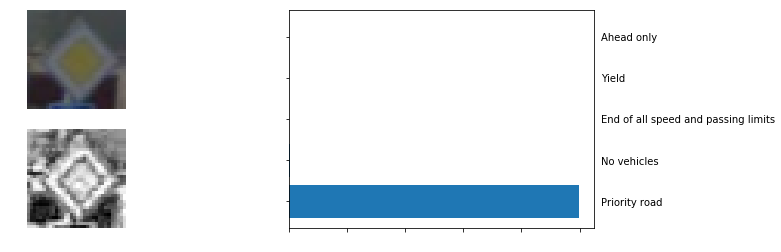

Top prediction 0.9987


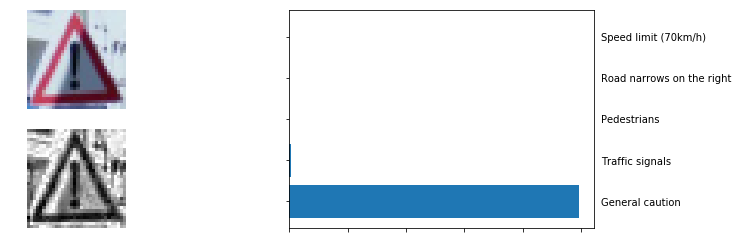

Top prediction 0.9935


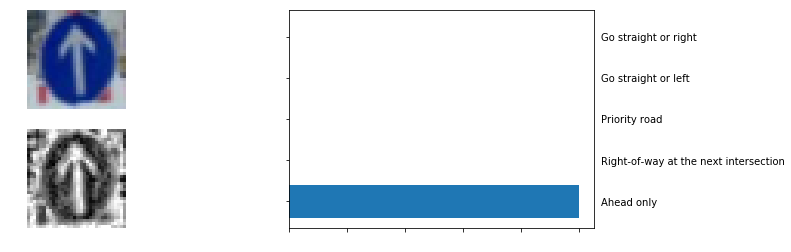

Top prediction 0.9999


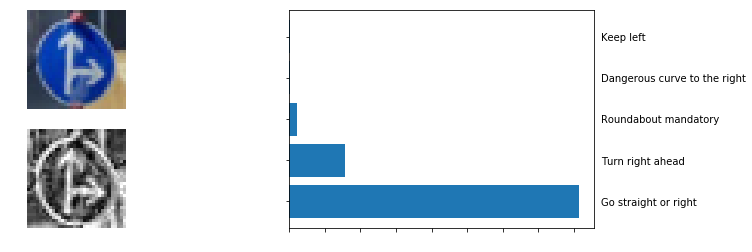

Top prediction 0.8149


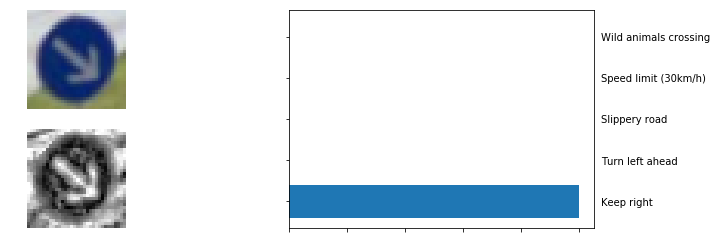

Top prediction 0.9997


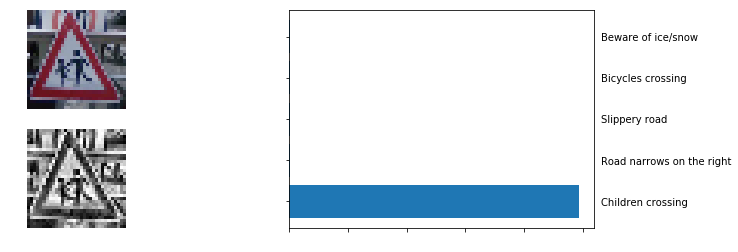

Top prediction 0.9874


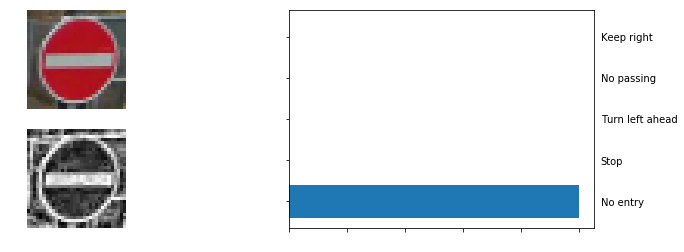

Top prediction 1.0


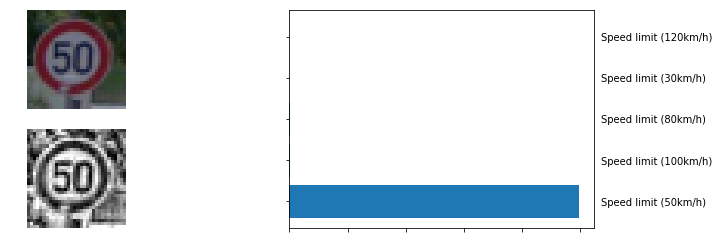

Top prediction 0.9957


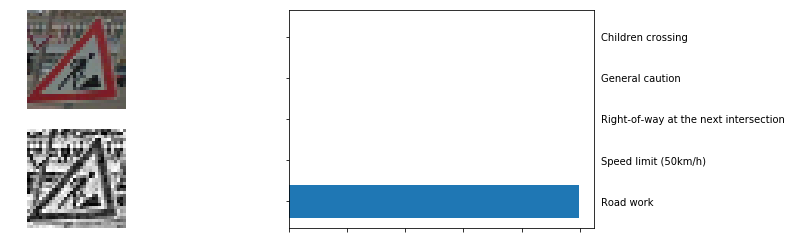

Top prediction 0.9986


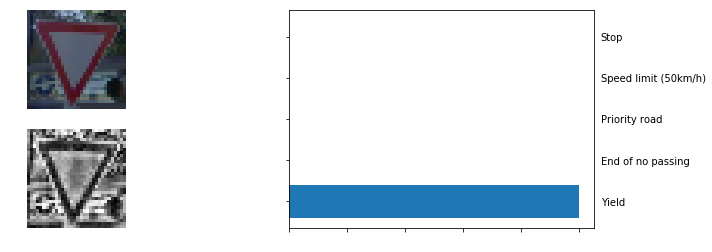

Top prediction 1.0


In [39]:
filenames = ['new_test_image/12_Priority_road.jpg',
             'new_test_image/18_General_caution.jpg',
             'new_test_image/35_Ahead_only.jpg',
             'new_test_image/36_Go_straight_or_right.jpg',
             'new_test_image/38_Keep_right.jpg',
             'new_test_image/28_Children_crossing.png',
             'new_test_image/17_No_entry.png',
             'new_test_image/2_Speed_limit (50km:h).png',
             'new_test_image/25_Road work.png',
             'new_test_image/13_Yield.png']


with tf.Session() as sess:
    loader = tf.train.import_meta_graph('traffic-sign.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    for file in filenames:
        og_img = io.imread(file)
        resized_img = resize(og_img, (32, 32))
        preprocessed_img = preprocess_image2(resized_img)
        reshaped_img = preprocessed_img.reshape((1,)+preprocessed_img.shape+(1,))
        
        score = sess.run(predictions, feed_dict = {input_data: reshaped_img, train_mode:False})
        get_top_k_prediction = tf.nn.top_k(score, 5)
    
        top_k_prediction = sess.run(get_top_k_prediction)
        
        test_score_plot(resized_img, preprocessed_img, top_k_prediction)
        

> Accuracy on 10 captured images are 100%. Although I randomly cropped traffic signs from google street view, I think new test image is not enough to real test the performance. My model is trained on imbalanced data. It will make wrong predictions where classes we don't have enough data to train as result.

> I think it is enough to get great performance as this time.  However, I believe model make a progress with augmented data(projection, flip, projection..) and balancing data. 